In [1]:
import sys
import ray
import time
import math
import os
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ray.init()

2022-09-16 18:02:58,503	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.28.6.160',
 'raylet_ip_address': '172.28.6.160',
 'redis_address': '172.28.6.160:6379',
 'object_store_address': '/tmp/ray/session_2022-09-16_18-02-57_945189_46259/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-09-16_18-02-57_945189_46259/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-09-16_18-02-57_945189_46259',
 'metrics_export_port': 33456,
 'node_id': '3c24aaced9b36730034db68b93c506de1d89a0d9'}

In [3]:
prefix = ""
traffic_config_template = {
    "wkld" : "FbHdp_distribution",
    "nhost" : 64,
    "load" : 0.6,
    "time_s" : 0.1,
    "incast" : 0,
    "pattern" : 0,
    "priority" : 0,
}

cc_config_template = { 
    "cc" : "",
    "slow_unit" : 0,
    "ack_highprio" : 1,
    "schedule" : 0,
    "abc_dt" : 0,
    "abc_delta" : 12000, 
    "abc_token" : 50,
    "abc_eta" : 0.95,
    "utgt" : 95,
    "abc_dqinterval" : 1000,
    "abc_tokenminbound" : 1,
    "abc_ratebound" : 0,
    "abc_markmode" : 1,
    "abc_brake_lastrtt" : 0
}
def configlst_to_namelst(config_lst):
    lst = []
    for config in config_lst:
        if config['cc'].find('abc') != -1:
            cc_name = "{}dt{:.1f}dl{:.1f}token{}eta{}mark{}".format(config['cc'], float(config['abc_dt']), float(config['abc_delta']),
                                                  config['abc_token'], config['abc_eta'], config['abc_markmode'])
            if(int(config['abc_tokenminbound']) ==0):
                cc_name+= "noTkMin"
            cc_name += "dq{}".format(config['abc_dqinterval'])
            if(int(config['abc_brake_lastrtt'])):
                cc_name+= "LRtt"
            if (int(config['abc_ratebound'])):
                cc_name+= "rb"
            lst.append(cc_name)
        elif config['cc'] == 'hp':
            lst.append("hp{}ai80".format(config['utgt']))
        else:
             lst.append(config['cc'])
    return lst

cmd_template="""--c {cc} \
    --schedule {schedule} \
    --bw 100 \
    --topo 2layer \
    --hpai 80 \
    --slow_unit {slow_unit} \
    --ack_highprio {ack_highprio} \
    --abc_dt {abc_dt}  \
    --abc_delta {abc_delta} \
    --abc_token {abc_token} \
    --abc_eta {abc_eta} \
    --utgt {utgt} \
    --abc_dqinterval {abc_dqinterval} \
    --abc_tokenminbound {abc_tokenminbound} \
    --abc_ratebound {abc_ratebound} \
    --abc_markmode {abc_markmode} \
    --abc_brake_lastrtt {abc_brake_lastrtt}
"""
@ray.remote
def launch(trace, cc_config):    
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation"
    os.chdir(work_dir)
    cmd = cmd_template.format(**cc_config)
    print("python run.py --trace {} {}".format(trace, cmd))
    os.system("python run.py --trace {} {}".format(trace, cmd))

def gen_trafic_config(traffic_config):
    wkld = traffic_config['wkld']
    nhost = traffic_config['nhost']
    load = traffic_config['load']
    time_s = traffic_config['time_s']
    incast = traffic_config['incast']
    pattern = traffic_config['pattern'] 
    priority = traffic_config['priority'] 
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/traffic_gen"
    os.chdir(work_dir)
    output_name = "{}_n{}_load{}_t{}_incast{}_pattern{}".format(wkld, nhost, load, time_s, incast, pattern)
    if(priority):
        output_name += "_priority1"
    
    #Check if requried file already exist
    dataset_files = os.listdir("/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix")
    for file in dataset_files:
         if file.find(output_name + ".txt") !=-1:
                #Already generate required files
                return output_name
            
    cmd = "python traffic_gen.py -c {}.txt -n {} -l {} -b 100G -t {} -o {}.txt -i {} -p {} -y {}".format(wkld, nhost, load, time_s, output_name, incast, pattern, priority)
    os.system(cmd)
    mix_path =  work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix"
    os.system("cp ./{}.txt {}".format(output_name, mix_path))
    return output_name

In [5]:
import copy
#"1longflow"


w4_l60_config = copy.deepcopy(traffic_config_template)
w4_l60 = gen_trafic_config(w4_l60_config)


w4_l30_incast_config = copy.deepcopy(traffic_config_template)
w4_l30_incast_config['load'] = 0.3
w4_l30_incast_config['incast'] = 1
w4_l30_incast = gen_trafic_config(w4_l30_incast_config)

w4_l30_config = copy.deepcopy(traffic_config_template)
w4_l30_config['load'] = 0.3
w4_l30_config['incast'] = 0
w4_l30 = gen_trafic_config(w4_l30_config)

w4_l10_config = copy.deepcopy(traffic_config_template)
w4_l10_config['load'] = 0.1
w4_l10_config['incast'] = 0
w4_l10 = gen_trafic_config(w4_l10_config)

w4_l90_config = copy.deepcopy(traffic_config_template)
w4_l90_config['load'] = 0.9
w4_l90_config['incast'] = 0
w4_l90 = gen_trafic_config(w4_l90_config)

w4_l80_config = copy.deepcopy(traffic_config_template)
w4_l80_config['load'] = 0.8
w4_l80_config['incast'] = 0
w4_l80 = gen_trafic_config(w4_l80_config)

w5_l30_incast_config = copy.deepcopy(traffic_config_template)
w5_l30_incast_config['wkld'] =  "WebSearch_distribution"
w5_l30_incast_config['load'] = 0.3
w5_l30_incast_config['incast'] = 1
w5_l30_incast = gen_trafic_config(w5_l30_incast_config)

w5_l60_config = copy.deepcopy(traffic_config_template)
w5_l60_config['wkld'] =  "WebSearch_distribution"
w5_l60 = gen_trafic_config(w5_l60_config)

w5_l60_prio_config = copy.deepcopy(traffic_config_template)
w5_l60_prio_config['wkld'] =  "WebSearch_distribution"
w5_l60_prio_config['priority'] = 1
w5_l60_prio = gen_trafic_config(w5_l60_prio_config)

w4_l60_prio_config = copy.deepcopy(traffic_config_template)
w4_l60_prio_config['priority'] = 1
w4_l60_prio = gen_trafic_config(w4_l60_prio_config)

w4_l80_prio_config = copy.deepcopy(traffic_config_template)
w4_l80_prio_config['load'] = 0.8
w4_l80_prio_config['incast'] = 0
w4_l80_prio_config['priority'] = 1
w4_l80_prio = gen_trafic_config(w4_l80_prio_config)

w4_l80_prio_incast_config = copy.deepcopy(traffic_config_template)
w4_l80_prio_incast_config['load'] = 0.8
w4_l80_prio_incast_config['incast'] = 1
w4_l80_prio_incast_config['priority'] = 1
w4_l80_prio_incast = gen_trafic_config(w4_l80_prio_incast_config)


cc_config_lst = []

# for cc in ["abc"]:
#     for abc_eta in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [1]:
#                             cc_config = copy.deepcopy(cc_config_template)
#                             cc_config['cc']  = cc
#                             cc_config['abc_eta'] = abc_eta
#                             cc_config['abc_token'] = abc_token
#                             cc_config['abc_delta'] = abc_delta
#                             cc_config['abc_dqinterval'] =  abc_dqinterval
#                             cc_config['abc_tokenminbound'] = abc_tokenminbound
#                             cc_config['abc_markmode'] = abc_markmode
#                             cc_config_lst.append(cc_config)

for cc in ["abc"]:
    for abc_eta in [0.95]:
        for abc_token in [50]:
            for abc_delta in [12000]:
                for abc_dqinterval in [1000]:
                    for abc_tokenminbound in [1]:
                        for abc_markmode in [1, 11]:
                            for schedule in [0]:
                                for abc_ratebound in [1]:
                                    cc_config = copy.deepcopy(cc_config_template)
                                    cc_config['cc']  = cc
                                    cc_config['abc_eta'] = abc_eta
                                    cc_config['abc_token'] = abc_token
                                    cc_config['abc_delta'] = abc_delta
                                    cc_config['abc_dqinterval'] =  abc_dqinterval
                                    cc_config['abc_tokenminbound'] = abc_tokenminbound
                                    cc_config['abc_markmode'] = abc_markmode
                                    cc_config['abc_ratebound'] = abc_ratebound
                                    cc_config['abc_brake_lastrtt'] = 1
                                    cc_config['schedule'] = schedule
                                    cc_config_lst.append(cc_config)


# for cc in ["dcqcn", "hp", "dctcp"]:
#     for schedule in [0]:
#         cc_config = copy.deepcopy(cc_config_template)
#         cc_config['cc']  = cc
#         cc_config['schedule'] = schedule
#         cc_config_lst.append(cc_config)


lst = []
wkld_lst = [w5_l60]
#wkld_lst = ["1longflow"]
# wkld_lst = ["singleflow"]
# wkld_lst = ['1lf_10incast']
# wkld_lst = [w4_l60]
# wkld_lst = ['M_FbHdp']
# wkld_lst = [w4_l60]
# wkld_lst = ["1lf_2incast_prio"]
# wkld_lst = ["1lf_3incast"]
# wkld_lst = ["2lf"]
# wkld_lst = [w4_l30_incast]
# wkld_lst = ["FbHdp_distribution_n2_load0.6_t0.010_inject1_repeat1"]
# wkld_lst = ["1lf_2incast"]
for cc_config in cc_config_lst:
    for wkld in wkld_lst:
        f_id = launch.remote(wkld, cc_config)
        lst.append(f_id)                        
#             ray.wait(lst, num_returns=len(lst))
#             lst = []

In [33]:
import subprocess
import argparse

def get_pctl(a, p):
    i = int(len(a) * p)
    return a[i]

def get_results_df(cc, prefix, percent = 50):
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/analysis/"
    cmd = 'python {}/fct_analysis.py -c {} -p {}'.format(work_dir, cc, prefix)
    print(cmd)
    x = subprocess.check_output(cmd, shell=True)
    lines = x.decode().split("\n")
    find_fct = False
    fsize_lst = []
    fct_lst = []
    for line in lines:
        if len(line) == 0:
            continue
        print(line)
        if(line.find('FCT') != -1):
            find_fct = True
        elif (find_fct):
            fsize_lst.append(int(line.split(',')[0]))
            percent_to_idx = {50:1, 95:2, 99:3}
            fct_lst.append(float(line.split(',')[percent_to_idx[percent]]))
    
    #generate DataFrame
    lst = {}     
    lst["FlowSize"] = fsize_lst
    if(prefix.find('schedule0')!= -1):
        fct_name = 'RR_' + cc
    elif(prefix.find('schedule1')!= -1):
        fct_name = 'SP_' + cc
    elif(prefix.find('schedule2')!= -1):
        fct_name = 'WRR_' + cc
    else:
        fct_name = cc
    lst[fct_name] = fct_lst
    return pd.DataFrame(lst)
    

def concat_df(df_lst):
    df = df_lst[0]
    for i in range(1, len(df_lst)):
        df = pd.concat([df, df_lst[i]])
    return df

name_map = {
'abc': 'ABC',
'mark11': '_Piecewise_Token',    
'mark10': '_Piecewise_PhantomQ',
'mark1': '_Vanilla',
'mark2': '_Piecewise',
'mark3': 'WRED_NegKmin',
'mark4': 'WRED_0Kmin',
'mark5' : 'AvgQLen',
'mark6': 'TokenInBytes',
'mark7' : '_Vanilla_ConsiderACK',
# 'mark7' : '',
'mark8' : '_QBuildRate',
'mark9' : '_QBuildRate_ConsiderACK',
#  'mark9' : '_QBuildRate',   
'noTkMin' : 'NoTokenLimit',
'rb' : '_ratebound',
'dq0': '_Dq2pkts',
'dq' : '_Dq',
#     'rb' : '',
# 'dq0': '',
'LRtt': '_BrakeLastRtt',
'dt0.0dl12000.0token50eta0.95' : ''
       }
def single_str_translate(name): 
        for key in name_map.keys():
            name = name.replace(key, name_map[key])
        return name
    
def variable_name_translate(df):
    for key in name_map.keys():
        df['variable'] = [ single_str_translate(name) for name in df['variable'] ]
    return df

                   
percent = 95

df = []
#common_prefix = "2layer_FbHdp_distribution_n64_load0.3_t0.1_incast1_pattern0_ackHigh1_schedule0" 
#common_prefix = "2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_schedule0" 
common_prefix = "2layer_M_FbHdp_ackHigh1_schedule1" 

#common_prefix = "2layer_WebSearch_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_schedule0" 


# common_prefix = "2layer_1longflow_ackHigh1_schedule0"

#common_prefix = "2layer_WebSearch_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1" 
#common_prefix = "2layer_1longflow_ackHigh1" 
#common_prefix = "2layer_singleflow_ackHigh1" 
#common_prefix = "2layer_1lf_10incast_ackHigh1" 
prefix = "fct_" + common_prefix 



cc_config_lst = []

# for cc in ["abc"]:
#     for abc_eta in [0.95]:
#         for abc_token in [50]:
#             for abc_delta in [8000]:
#                 for abc_dqinterval in [0]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [7, 9]:
#                             for abc_brake_lastrtt in [1]:
# #                                 if ( abc_markmode == 9 and abc_brake_lastrtt ==0):
# #                                     continue
#                                 cc_config = copy.deepcopy(cc_config_template)
#                                 cc_config['cc']  = cc
#                                 cc_config['abc_eta'] = abc_eta
#                                 cc_config['abc_token'] = abc_token
#                                 cc_config['abc_delta'] = abc_delta
#                                 cc_config['abc_dqinterval'] =  abc_dqinterval
#                                 cc_config['abc_tokenminbound'] = abc_tokenminbound
#                                 cc_config['abc_markmode'] = abc_markmode
#                                 cc_config['abc_ratebound'] = 1
#                                 cc_config['abc_brake_lastrtt'] = abc_brake_lastrtt
#                                 cc_config_lst.append(cc_config)

# for cc in ["abc"]:
#     for abc_eta in [0.95]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [1]:
#                             for schedule in [1]:
#                                 for abc_ratebound in [1]:
#                                     cc_config = copy.deepcopy(cc_config_template)
#                                     cc_config['cc']  = cc
#                                     cc_config['abc_eta'] = abc_eta
#                                     cc_config['abc_token'] = abc_token
#                                     cc_config['abc_delta'] = abc_delta
#                                     cc_config['abc_dqinterval'] =  abc_dqinterval
#                                     cc_config['abc_tokenminbound'] = abc_tokenminbound
#                                     cc_config['abc_markmode'] = abc_markmode
#                                     cc_config['abc_ratebound'] = abc_ratebound
#                                     cc_config['abc_brake_lastrtt'] = 0
#                                     cc_config['schedule'] = schedule
#                                     cc_config_lst.append(cc_config)

for cc in ["dctcp"]:
        cc_config = copy.deepcopy(cc_config_template)
        cc_config['cc']  = cc
        cc_config_lst.append(cc_config)
        
for cc in ["dcqcn"]:
        cc_config = copy.deepcopy(cc_config_template)
        cc_config['cc']  = cc
        cc_config_lst.append(cc_config)
        
for cc in ["hp"]:
        cc_config = copy.deepcopy(cc_config_template)
        cc_config['cc']  = cc
        cc_config_lst.append(cc_config)
        


    


for cc in ["abc"]:
    for abc_eta in [0.95]:
        for abc_token in [50]:
            for abc_delta in [12000]:
                for abc_dqinterval in [1000]:
                    for abc_tokenminbound in [1]:
                        for abc_markmode in [1]:
                            for schedule in [2]:
                                for abc_ratebound in [1]:
                                    cc_config = copy.deepcopy(cc_config_template)
                                    cc_config['cc']  = cc
                                    cc_config['abc_eta'] = abc_eta
                                    cc_config['abc_token'] = abc_token
                                    cc_config['abc_delta'] = abc_delta
                                    cc_config['abc_dqinterval'] =  abc_dqinterval
                                    cc_config['abc_tokenminbound'] = abc_tokenminbound
                                    cc_config['abc_markmode'] = abc_markmode
                                    cc_config['abc_ratebound'] = abc_ratebound
                                    cc_config['abc_brake_lastrtt'] = 0
                                    cc_config['schedule'] = schedule
                                    cc_config_lst.append(cc_config)
# for cc in ["abc"]:
#     for abc_eta in [0.95]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [7]:
#                             for schedule in [0]:
#                                 for abc_ratebound in [1]:
#                                     cc_config = copy.deepcopy(cc_config_template)
#                                     cc_config['cc']  = cc
#                                     cc_config['abc_eta'] = abc_eta
#                                     cc_config['abc_token'] = abc_token
#                                     cc_config['abc_delta'] = abc_delta
#                                     cc_config['abc_dqinterval'] =  abc_dqinterval
#                                     cc_config['abc_tokenminbound'] = abc_tokenminbound
#                                     cc_config['abc_markmode'] = abc_markmode
#                                     cc_config['abc_ratebound'] = abc_ratebound
#                                     cc_config['abc_brake_lastrtt'] = 0
#                                     cc_config['schedule'] = schedule
#                                     cc_config_lst.append(cc_config)



for cc in ["abc"]:
    for abc_eta in [0.95]:
        for abc_token in [50]:
            for abc_delta in [12000]:
                for abc_dqinterval in [1000]:
                    for abc_tokenminbound in [1]:
                        for abc_markmode in [11]:
                            for schedule in [0]:
                                for abc_ratebound in [1]:
                                    cc_config = copy.deepcopy(cc_config_template)
                                    cc_config['cc']  = cc
                                    cc_config['abc_eta'] = abc_eta
                                    cc_config['abc_token'] = abc_token
                                    cc_config['abc_delta'] = abc_delta
                                    cc_config['abc_dqinterval'] =  abc_dqinterval
                                    cc_config['abc_tokenminbound'] = abc_tokenminbound
                                    cc_config['abc_markmode'] = abc_markmode
                                    cc_config['abc_ratebound'] = abc_ratebound
                                    cc_config['abc_brake_lastrtt'] = 0
                                    cc_config['schedule'] = schedule
                                    cc_config_lst.append(cc_config)
                                    

df_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    df_lst.append(get_results_df(cc=cc, prefix=prefix, percent=percent))
    
# for cc in configlst_to_namelst(cc_config_lst):
#     df_lst.append(get_results_df(cc=cc, prefix="fct_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1",percent=percent))

# for cc in configlst_to_namelst(cc_config_lst):
#     df_lst.append(get_results_df(cc=cc, prefix=prefix.replace('schedule0','schedule1'), percent=percent))
df = concat_df(df_lst)



python /home/cxyzhao/High-Precision-Congestion-Control/analysis//fct_analysis.py -c dctcp -p fct_2layer_M_FbHdp_ackHigh1_schedule1
dctcp 0.03 95.38
FCT
299,1.000,1.046,1.090,
324,1.001,1.048,1.094,
349,1.001,1.048,1.092,
398,1.002,1.049,1.097,
448,1.003,1.050,1.093,
498,1.004,1.050,1.096,
549,1.004,1.053,1.095,
599,1.005,1.052,1.094,
649,1.006,1.054,1.098,
699,1.007,1.055,1.100,
849,1.009,1.056,1.100,
999,1.011,1.059,1.101,
1717,1.021,1.136,1.237,
7402,1.043,1.339,1.644,
36052,1.855,4.554,6.135,
46093,2.132,4.772,6.244,
67995,2.250,5.232,7.000,
119366,2.497,5.881,8.340,
299074,2.999,7.667,11.044,
9997010,3.709,9.946,14.356,
python /home/cxyzhao/High-Precision-Congestion-Control/analysis//fct_analysis.py -c dcqcn -p fct_2layer_M_FbHdp_ackHigh1_schedule1
dcqcn 0.04 95.38
FCT
299,1.000,1.045,1.091,
324,1.000,1.046,1.092,
349,1.001,1.047,1.093,
398,1.001,1.049,1.094,
448,1.002,1.048,1.094,
498,1.003,1.049,1.096,
549,1.004,1.051,1.094,
599,1.005,1.051,1.095,
649,1.006,1.053,1.097,
699,1.007

/home/cxyzhao/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/cxyzhao/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


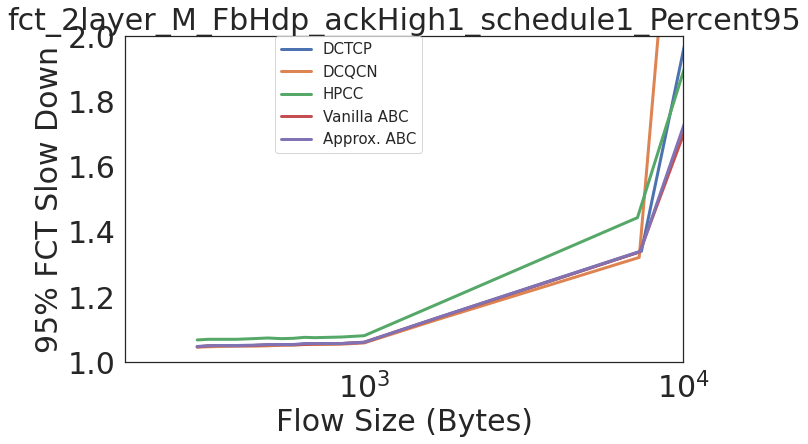

In [39]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('white')
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
data_ = variable_name_translate(pd.melt(df, 'FlowSize'))
# data_.columns= ['Vanilla', '+BrakeLastRtt', '+QueueBuidupRate', 'HPCC']
g= sns.lineplot('FlowSize', 'value', hue='variable', data=data_ , linewidth = 3)
g.set_title("{}_Percent{}".format(prefix, percent), fontsize = 30)
# g.set_title("Multiple Traffic Class (Long Flow)", fontsize = 30)
# g.set_title("60% Network Load", fontsize = 30)
# g.set_title("30% Load + Incast  ", fontsize = 30)
g.set_xscale('log')
# g.set_yticks([1.0, 1.5, 2.0, 2.5, 3.0])
g.set(xlim=(0, 10000))
g.set(ylim=(1., 2))
g.set_xlabel("Flow Size (Bytes)", fontsize = 30)
g.set_ylabel("95% FCT Slow Down", fontsize = 30)
plt.legend(['DCTCP', 'DCQCN', 'HPCC', 'Vanilla ABC', 'Approx. ABC'], loc=10,fontsize = 15, borderaxespad=0.,bbox_to_anchor=(0.4, 0.82))


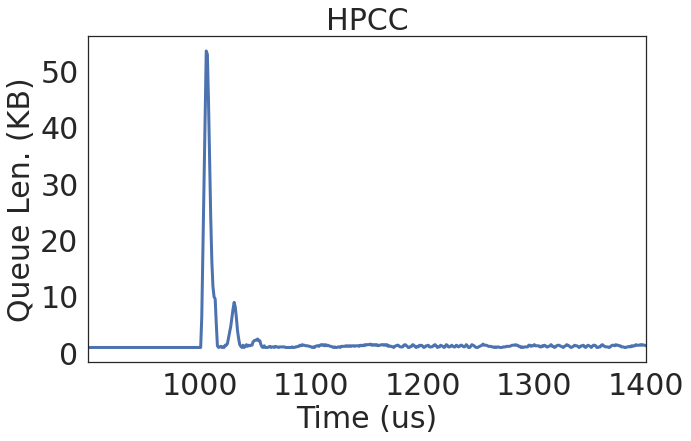

In [1362]:
def get_avg_qlen(df):
    df = df.fillna(0.0)
    tseries_qlen_avg = []
    for column in df.columns[0:]:
        if column == 0:
            delta_qlen_dist = df[column]
        else:
            delta_qlen_dist = df[column] - df[column-1]
        total_cnt = 0.0
        total_val = 0.0
        max_val = 0.0 
        for i in range(1, len(delta_qlen_dist)):
            total_val += delta_qlen_dist[i] * i
            total_cnt += delta_qlen_dist[i]
            if(delta_qlen_dist[i]!=0 and i > max_val):
                max_val = i
        tseries_qlen_avg.append(total_val / total_cnt)
#         tseries_qlen_avg.append(max_val)
    return pd.DataFrame(tseries_qlen_avg, columns=["Avg_qLen"])

qlen_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
# common_prefix = "2layer_2lf_ackHigh1_schedule2" 

common_prefix = "2layer_1lf_2incast_ackHigh1_schedule0"
prefix = "qlen_" + common_prefix + "_"

cc_config_lst = []
for cc in ["hp"]:
    cc_config = copy.deepcopy(cc_config_template)
    cc_config['cc']  = cc
    cc_config_lst.append(cc_config)
    
# for cc in ["dcqcn"]:
#     cc_config = copy.deepcopy(cc_config_template)
#     cc_config['cc']  = cc
#     cc_config_lst.append(cc_config)

# for cc in ["abc"]:
#     for abc_eta in [0.95]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [1]:
#                             for schedule in [0]:
#                                 for abc_ratebound in [1]:
#                                     cc_config = copy.deepcopy(cc_config_template)
#                                     cc_config['cc']  = cc
#                                     cc_config['abc_eta'] = abc_eta
#                                     cc_config['abc_token'] = abc_token
#                                     cc_config['abc_delta'] = abc_delta
#                                     cc_config['abc_dqinterval'] =  abc_dqinterval
#                                     cc_config['abc_tokenminbound'] = abc_tokenminbound
#                                     cc_config['abc_markmode'] = abc_markmode
#                                     cc_config['abc_ratebound'] = abc_ratebound
#                                     cc_config['abc_brake_lastrtt'] = 1
#                                     cc_config['schedule'] = schedule
#                                     cc_config_lst.append(cc_config)

    
qlen_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    qlen_name_lst.append(prefix+cc)

all_df = pd.DataFrame()
name_start_pos = 0
for qlen_name in qlen_name_lst:
    df =pd.DataFrame()
    qlen_file = qlen_dir + qlen_name + ".txt"
    cc_name  = qlen_name[name_start_pos:]
    port_to_qlenDist = {}
    with open(qlen_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("2004000000") != -1:
                break
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [int(i) for i in lst]
                name = "switch{}port{}queue{}".format(lst[0], lst[1], lst[2])
                if name not in port_to_qlenDist.keys():
                    port_to_qlenDist[name] = []
                port_to_qlenDist[name].append(lst[2:])
    key = "switch64port2queue3"           
    avg_qlen = get_avg_qlen(pd.DataFrame(port_to_qlenDist[key]).T)
    avg_qlen.columns = [cc_name]
    df = pd.concat([df, avg_qlen])
    df.columns = [single_str_translate(name) for name in df.columns]
    all_df = pd.concat([all_df, df])
    
    

sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)


g= sns.lineplot(data=all_df, linewidth=3)

g.set_title("HPCC", fontsize = 30)
g.set_xlabel("Time (us)", fontsize = 30)
# g.set(ylim=(0, 25))
g.set(xlim=(900, 1400))
g.set_xticks([1000, 1100, 1200, 1300, 1400])
g.set_ylabel("Queue Len. (KB)", fontsize = 30)
plt.legend(bbox_to_anchor=(0, -0.2), loc=2, borderaxespad=0.)
plt.legend([],[], frameon=False)



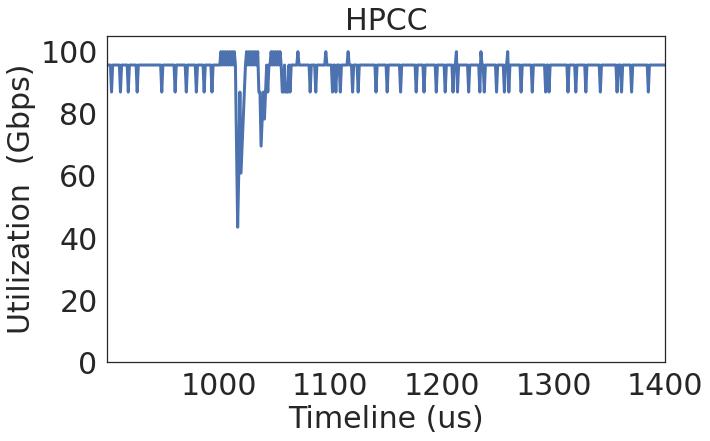

In [1361]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def tranfer_name(cc_name):
    cc_name = cc_name.replace("aabc", "pw-abc")
    cc_name = cc_name.replace("rabc", "wr-abc")
    return cc_name

link_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"


prefix = "link_" + common_prefix + "_"
link_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    link_name_lst.append(prefix+cc)
    
df =pd.DataFrame()
for link_name in link_name_lst:
    link_file = link_dir + link_name + ".txt"
    cc_name  = link_name[:]
    port_to_linkutil_series = {}
    with open(link_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [float(i) for i in lst]
                if(len(lst) < 2):
                    continue
                name = "switch{}port{}".format(int(lst[0]), int(lst[1]))
                if name not in port_to_linkutil_series.keys():
                    port_to_linkutil_series[name] = []
                port_to_linkutil_series[name].append(lst[2])


    cc_name  = tranfer_name(cc_name)
    df = pd.concat([df, pd.DataFrame(port_to_linkutil_series["switch64port2"], columns=[cc_name]) ], axis=1)




# accu_avg = df.expanding().mean()
# #accu_avg.columns = ["CumulativeAverage-Vanilla", "CumulativeAverage-PW", "CumulativeAverage-WRED", "CumulativeAverage-HPCC"]
# accu_avg.columns = ["CumulativeAverage-1", "CumulativeAverage-2", "CumulativeAverage-3"]
# df = pd.concat([df, accu_avg])

df = df.applymap(lambda a:  100 if a  > 100  else a)
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

df.columns = [single_str_translate(name) for name in df.columns]
g= sns.lineplot(data=df, linewidth = 3)

g.set_title("HPCC", fontsize = 30)
g.set_xlabel("Timeline (us)", fontsize = 30)
g.set_ylabel("Utilization  (Gbps)", fontsize = 30)
g.set(ylim=(0, 105))
g.set(xlim=(900, 1400))
g.set_xticks([1000, 1100, 1200, 1300, 1400])
plt.legend(bbox_to_anchor=(0, -0.2), loc=2, borderaxespad=0.)
plt.legend([],[], frameon=False)


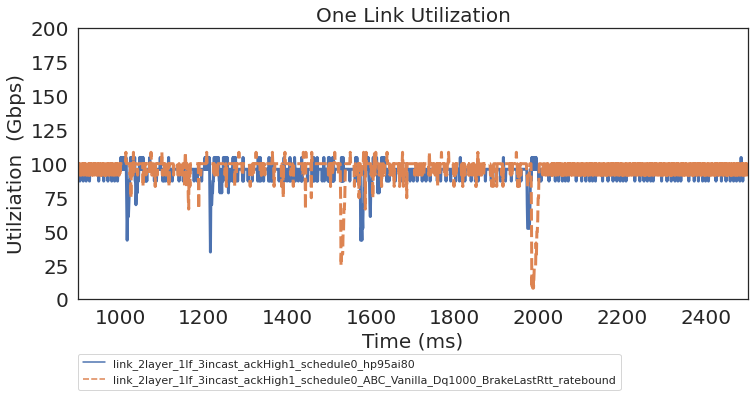

In [1333]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

df.columns = [single_str_translate(name) for name in df.columns]
g= sns.lineplot(data=df, linewidth = 3)

g.set_title("One Link Utilization", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("Utilziation  (Gbps)", fontsize = 20)
g.set(ylim=(0, 200))
g.set(xlim=(900, 2500))
plt.legend(bbox_to_anchor=(0, -0.2), loc=2, borderaxespad=0.)
#plt.legend([],[], frameon=False)

Text(0, 0.5, 'CDF')

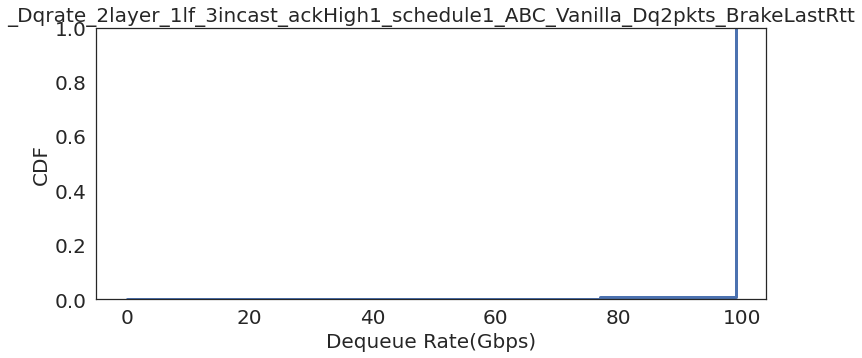

In [255]:
#For dqrate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dqrate_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"

#prefix = "dqrate_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_"
common_prefix = "2layer_1lf_3incast_ackHigh1_schedule1" 
prefix = "dqrate_" + common_prefix + "_"

cc_config_lst = []
for cc in ["abc"]:
    for abc_eta in [0.95]:
        for abc_token in [50]:
            for abc_delta in [12000]:
                for abc_dqinterval in [0]:
                    for abc_tokenminbound in [1]:
                        for abc_markmode in [1]:
                            for schedule in [1]:
                                for abc_ratebound in [0]:
                                    cc_config = copy.deepcopy(cc_config_template)
                                    cc_config['cc']  = cc
                                    cc_config['abc_eta'] = abc_eta
                                    cc_config['abc_token'] = abc_token
                                    cc_config['abc_delta'] = abc_delta
                                    cc_config['abc_dqinterval'] =  abc_dqinterval
                                    cc_config['abc_tokenminbound'] = abc_tokenminbound
                                    cc_config['abc_markmode'] = abc_markmode
                                    cc_config['abc_ratebound'] = abc_ratebound
                                    cc_config['abc_brake_lastrtt'] = 1
                                    cc_config['schedule'] = schedule
                                    cc_config_lst.append(cc_config)
                            
dqrate_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    dqrate_name_lst.append(prefix+cc)

df =pd.DataFrame()
time = ""
for dqrate_name in dqrate_name_lst:
    dqrate_file = dqrate_dir + dqrate_name + ".txt"
    cc_name  = dqrate_name[:]
    port_to_dqrateDist = {}
    with open(dqrate_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                time = line
                continue
            else:
                lst = line.split()
                lst = [int(i) for i in lst]
                name = "switch{}port{}queue{}".format(lst[0], lst[1], lst[2])
                if name not in port_to_dqrateDist.keys():
                    port_to_dqrateDist[name] = []
                port_to_dqrateDist[name].append(lst[3:])
#                 if (len(lst[3:]) > 1000):
#                     print(name, len(lst[3:]), line)
    #dqrate = pd.DataFrame(port_to_dqrateDist["switch64port20queue3"]).T 
    #dqrate = pd.DataFrame(dqrate[30])
    dqrate = pd.DataFrame(pd.DataFrame(port_to_dqrateDist["switch64port2queue3"]).T)
    dqrate = dqrate[dqrate.columns[100:150]].sum(axis=1)
    df = pd.concat([df, dqrate])
    df.columns = [cc_name]
    
# #     avg_qlen = get_avg_qlen(pd.DataFrame(port_to_qlenDist["switch64port20queue3"]).T)
# #     avg_qlen.columns = [cc_name]
# #     df = pd.concat([df, avg_qlen])

sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


#g = sns.ecdfplot(data=df, linewidth=3, x=df.index)
g = sns.ecdfplot(data=df, linewidth=3, x=df.index, weights=cc_name)
#g = sns.lineplot(data=df, linewidth=3)

g.set_title(single_str_translate(cc_name), fontsize = 20)
g.set_xlabel("Dequeue Rate(Gbps)", fontsize = 20)
g.set_ylabel("CDF", fontsize = 20)
#g.set(xlim=(190, 200))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend([],[], frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


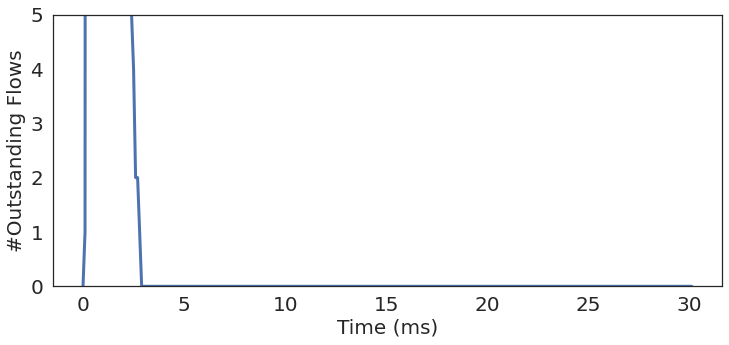

In [1128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def tranfer_name(cc_name):
    cc_name = cc_name.replace("aabc", "pw-abc")
    cc_name = cc_name.replace("rabc", "wr-abc")
    return cc_name

file_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"


prefix = "outflow_" + common_prefix + "_"
file_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    file_name_lst.append(prefix+cc)
    break
    


df =pd.DataFrame()
for file_name in file_name_lst:
    _file = file_dir + file_name + ".txt"
    cc_name  = _file[74:]
    counters = []
    with open(_file) as f:
        lines =f.readlines()
        #cur_counter  = [0 for i in range(64)]
        cur_counter = 0
        for line in lines:
            if line.find("time") != -1:
                counters.append(cur_counter)
                #cur_counter  = [0 for i in range(64)]
                cur_counter = 0
                continue
            else:
                lst = line.split()
                if(len(lst) < 3):
                    continue
                lst = [int(i) for i in lst]
                cur_counter += lst[2]


    cc_name  = tranfer_name(cc_name)
    cc_name = "ABC"
    df = pd.concat([df, pd.DataFrame(counters, columns=[cc_name]) ], axis=1)



df['Cumulative Moving Average'] = df.expanding().mean()

sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
g= sns.lineplot(data=df, x=df.index * 0.1, y='ABC', linewidth = 3)
#g.set_title("#Outstanding Flows", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("#Outstanding Flows", fontsize = 20)
g.set(ylim=(0, 5))
# g.set(xlim=(0, 30))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend([],[], frameon=False)



# For INT Header
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

header_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"

prefix = "header_" + common_prefix + "_"

cc_config_lst = []
for cc in ["abc"]:
    for abc_eta in [0.95]:
        for abc_token in [50]:
            for abc_delta in [12000]:
                for abc_dqinterval in [1000]:
                    for abc_tokenminbound in [1]:
                        for abc_markmode in [1]:
                            cc_config = copy.deepcopy(cc_config_template)
                            cc_config['cc']  = cc
                            cc_config['abc_eta'] = abc_eta
                            cc_config['abc_token'] = abc_token
                            cc_config['abc_delta'] = abc_delta
                            cc_config['abc_dqinterval'] =  abc_dqinterval
                            cc_config['abc_tokenminbound'] = abc_tokenminbound
                            cc_config['abc_markmode'] = abc_markmode
                            cc_config_lst.append(cc_config)

# for cc in ["dctcp", "dcqcn", "timely", "hp"]:
#     cc_config = copy.deepcopy(cc_config_template)
#     cc_config['cc']  = cc
#     cc_config_lst.append(cc_config)

    
header_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    header_name_lst.append(prefix+cc)

df =pd.DataFrame()
for header_name in header_name_lst:
    header_file = header_dir + header_name + ".txt"
    cc_name  = header_name[76:]
    port_to_header = {}
    with open(header_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [int(i) for i in lst]
                name = "switch{}port{}".format(lst[0], lst[1])
                if name not in port_to_header.keys():
                    port_to_header[name] = []
                port_to_header[name] =  lst[2:]
    col = ['txBytes_all_GB','txBytes_udp', 'txBytes_udp_wholeheader', 'txBytes_udp_intheader',\
           'txBytes_ack', 'txBytes_ack_wholeheader', 'txBytes_ack_intheader']            
    header = pd.DataFrame(port_to_header["switch66port20"]).T
    header.columns = col
    if(cc_name.find('abc')!=-1):
        cc_name = 'abc'
    header['cc'] = cc_name
    df  = pd.concat([df, header])
    

for i in range(1, len(col)):
    df[col[i]]  = df[col[i]] /df[col[0]]
df[col[0]] = df[col[0]] / 1000000000





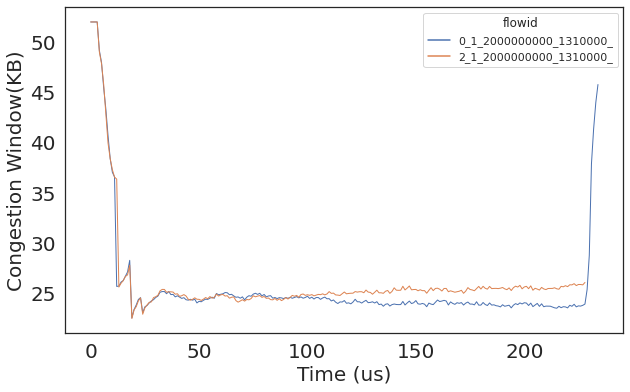

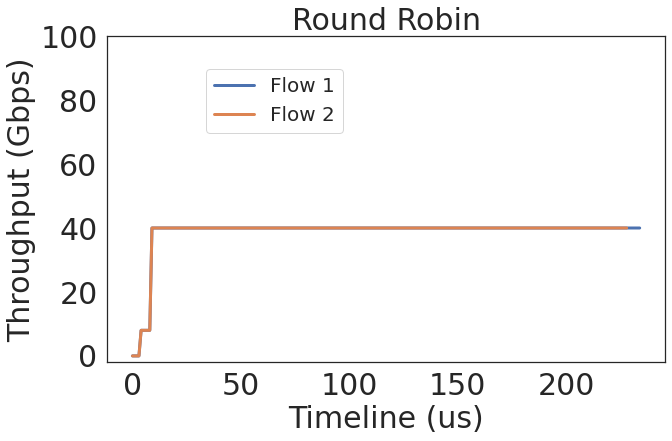

In [1402]:
cc_config_lst = []

# for cc in ["abc"]:
#     for abc_eta in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [1]:
#                             cc_config = copy.deepcopy(cc_config_template)
#                             cc_config['cc']  = cc
#                             cc_config['abc_eta'] = abc_eta
#                             cc_config['abc_token'] = abc_token
#                             cc_config['abc_delta'] = abc_delta
#                             cc_config['abc_dqinterval'] =  abc_dqinterval
#                             cc_config['abc_tokenminbound'] = abc_tokenminbound
#                             cc_config['abc_markmode'] = abc_markmode
#                             cc_config_lst.append(cc_config)

# for cc in ["abc"]:
#     for abc_eta in [0.95]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [0]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [2]:
#                             for schedule in [2]:
#                                 for abc_ratebound in [1]:
#                                     cc_config = copy.deepcopy(cc_config_template)
#                                     cc_config['cc']  = cc
#                                     cc_config['abc_eta'] = abc_eta
#                                     cc_config['abc_token'] = abc_token
#                                     cc_config['abc_delta'] = abc_delta
#                                     cc_config['abc_dqinterval'] =  abc_dqinterval
#                                     cc_config['abc_tokenminbound'] = abc_tokenminbound
#                                     cc_config['abc_markmode'] = abc_markmode
#                                     cc_config['abc_ratebound'] = abc_ratebound
#                                     cc_config['abc_brake_lastrtt'] = 0
#                                     cc_config['schedule'] = schedule
#                                     cc_config_lst.append(cc_config)

# for cc in ["dcqcn"]:
#     cc_config = copy.deepcopy(cc_config_template)
#     cc_config['cc']  = cc
#     cc_config_lst.append(cc_config)

for cc in ["hp"]:
    cc_config = copy.deepcopy(cc_config_template)
    cc_config['cc']  = cc
    cc_config_lst.append(cc_config)

#common_prefix = "2layer_FbHdp_distribution_n2_load0.6_t0.010_inject1_repeat1_ackHigh1_schedule0" 
# common_prefix = "2layer_1longflow_ackHigh1_schedule0"

# common_prefix = "2layer_1lf_2incast_ackHigh1_schedule0"
common_prefix = "2layer_2lf_ackHigh1_schedule0"
flowbw_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
# common_prefix = "2layer_2lf_ackHigh1_schedule2" 
prefix = "flowbw_" + common_prefix + "_"
flowbw_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    flowbw_name_lst.append(prefix+cc)

df =pd.DataFrame()
name_start_pos = 45
flowbw_trace = []
for flowbw_name in flowbw_name_lst:
    flowbw_file = flowbw_dir + flowbw_name + ".txt"
    cc_name  = flowbw_name[name_start_pos:]
    with open(flowbw_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [int(i) for i in lst]
                flowid = "{}_{}_{}_{}_{}".format(lst[0], lst[1], lst[2], lst[3], cc_name)
#                 if (flowid.find('0_1_2000000000_131000000') == -1):
#                     continue
                lst.append(flowid)
                lst.append(cc_name)
                flowbw_trace.append(lst)
                
                

                
df = pd.DataFrame(flowbw_trace, columns = ['sid', 'did', 'start_ts', 'bytes', 'cur_ts', 'cwnd', 'goodput','flowid', 'cc'])


#df = df[df['flowid'] == '0_1_2000000000_131000000']
df['cur_ts'] = (df['cur_ts'].astype(int)-df['cur_ts'].astype(int)[0]) / 1000
df['cwnd'] = df['cwnd']/1000
# # df = df[100:900]
# df = df[10000:25000]
df['acc'] = df['goodput'].rolling(1000).mean() 

# df = df.groupby(['cc','cur_ts']).agg('sum')
cc_name = single_str_translate(cc_name)
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('white')


#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
g= sns.lineplot(data=df, x='cur_ts', y='cwnd', hue='flowid', linewidth=1)
# g.set_title("StrictPriority_ABC_WithoutAI_Delta12us", fontsize = 20)
g.set_title(cc_name, fontsize = 20)
g.set_xlabel("Time (us)", fontsize = 20)
# g.set(xlim=(0, 2500))
g.set_ylabel("Congestion Window(KB)", fontsize = 20)
# plt.legend(bbox_to_anchor=(0, -0.2), loc=2, borderaxespad=0.)
# plt.legend([],[], frameon=False)
plt.show()
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
g= sns.lineplot(data=df, x='cur_ts', y='goodput', hue='flowid', linewidth=3)
g.set_yticks([10 * (i+1) for i in range(10)])
# g.set_title("StrictPriority_ABC_WithoutAI_Delta12us", fontsize = 20)
g.set_title("Round Robin", fontsize = 30)
g.set_xlabel("Timeline (us)", fontsize = 30)
# g.set(xlim=(500,2500))
# g.set(ylim=(10,20))
g.set_yticks([0,20,40,60,80,100])
g.set_ylabel("Throughput (Gbps)", fontsize = 30)
# plt.legend(['High-weight Flow', 'Low-weight Flow'], loc=10,fontsize = 20, borderaxespad=0.,bbox_to_anchor=(0.3, 0.8))
#plt.legend(['High-prio. Flow', 'Low-prio Flow'], loc=10,fontsize = 20, borderaxespad=0.,bbox_to_anchor=(0.3, 0.8))
plt.legend(['Flow 1', 'Flow 2'], loc=10,fontsize = 20, borderaxespad=0.,bbox_to_anchor=(0.3, 0.8))
# plt.legend(bbox_to_anchor=(0, -0.2), loc=2, borderaxespad=0.)
# plt.legend([],[], frameon=False)


In [1258]:
df

,sid,did,start_ts,bytes,cur_ts,cwnd,goodput,flowid,cc,acc
0,0,1,2000000000,131000000,0.0,52.000,0,0_1_2000000000_131000000_95ai80,95ai80,0.000000
1,0,1,2000000000,131000000,1.0,52.000,0,0_1_2000000000_131000000_95ai80,95ai80,0.000000
2,0,1,2000000000,131000000,2.0,52.000,0,0_1_2000000000_131000000_95ai80,95ai80,0.000000
3,0,1,2000000000,131000000,3.0,52.000,0,0_1_2000000000_131000000_95ai80,95ai80,0.000000
4,0,1,2000000000,131000000,4.0,49.465,16,0_1_2000000000_131000000_95ai80,95ai80,3.200000
...,...,...,...,...,...,...,...,...,...,...
36553,0,1,2000000000,131000000,36553.0,48.795,80,0_1_2000000000_131000000_95ai80,95ai80,24.148383
36554,0,1,2000000000,131000000,36554.0,49.021,88,0_1_2000000000_131000000_95ai80,95ai80,24.150130
36555,0,1,2000000000,131000000,36555.0,49.179,88,0_1_2000000000_131000000_95ai80,95ai80,24.151877
36556,0,1,2000000000,131000000,36556.0,48.842,88,0_1_2000000000_131000000_95ai80,95ai80,24.153623


In [383]:
with open('/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0.txt', 'r') as f:
    lines = f.readlines()
    with open('/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/M_FbHdp.txt', 'w') as ff:
        for line in lines:
            lst = line.split()
            if(len(lst)) < 2:
                ff.write(line + '\n')
            else:
                if(int(lst[4]) < 10000):
                    lst[2] = 1
                ff.write('{} {} {} {} {} {}\n'.format(lst[0], lst[1], lst[2], lst[3], lst[4], lst[5]))